#Домашнее задание 3

Генерация текста с помощью рекурентной нейронной сети (VanilaRNN)

In [2]:
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


from IPython.display import clear_output

In [3]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is avaible'.format(device))


cuda device is avaible


загрузка данных ("Евгений Онегин")

In [4]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2025-09-25 09:06:27--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2025-09-25 09:06:28 (14.2 MB/s) - ‘onegin.txt’ saved [262521/262521]



In [5]:
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]

Seems fine!


In [6]:
print(num_tokens)

84


RNN

In [7]:
batch_size=256
seq_lenght=100
start_column=np.zeros((batch_size,1),dtype=int)+token_to_idx["<sos>"]

def generate_chunk():
  global text_encoded, start_column, batch_size, seq_lenght

  start_index = np.random.randint(0,len(text_encoded)-batch_size*seq_lenght-1)
  data = np.array(text_encoded[start_index:start_index+batch_size*seq_lenght]).reshape((batch_size,-1))
  yield np.hstack((start_column, data))


пример батча

In [8]:
next(generate_chunk()).shape

(256, 101)

обучение модели

In [9]:
class Char_RNN(nn.Module):
  def __init__(self, rnn_num_units=512, num_tokens=num_tokens, embedding_size=128):
    super(self.__class__,self).__init__()

    self.num_units=rnn_num_units

    self.embedding=nn.Embedding(num_tokens,embedding_size)
    self.rnn_update=nn.Linear(rnn_num_units+embedding_size,rnn_num_units)
    self.rnn_to_logits=nn.Linear(rnn_num_units, num_tokens)
  def forward(self, x, h_prev):

    x_emb = self.embedding(x)
    #print(x_emb.shape,h_prev.shape)
    x_and_h = torch.cat([x_emb,h_prev], dim=-1)
    h_next=self.rnn_update(x_and_h)

    h_next=torch.tanh(h_next)

    logits=self.rnn_to_logits(h_next)
    return logits, h_next

  def initial_state(self, batch_size):
    return torch.zeros(batch_size, self.num_units, requires_grad=True)





In [10]:
model=Char_RNN()

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
loss_func=nn.CrossEntropyLoss()
opt =  torch.optim.Adam(model.parameters(),lr=5e-3)
lr_scheduler = ReduceLROnPlateau(opt, factor=0.5, patience=150)
history=[]
num_epochs=2500

In [13]:
def rnn_loop(char_rnn, batch_ix):

  max_lenght, batch_size = batch_ix.size()
  hid_state=char_rnn.initial_state(batch_size)
  all_logits=[]
  #print(batch_ix.shape,hid_state.shape)
  for x_t in batch_ix:
    #print(x_t.shape, hid_state.shape)
    logits_next, hid_state= char_rnn(
        x_t, hid_state
    )
    all_logits.append(logits_next)

  return torch.stack(all_logits,dim=1)


In [14]:
for i in range(num_epochs):
  opt.zero_grad()
  batch_ix=next(generate_chunk())
  batch_ix=torch.tensor(batch_ix,dtype=torch.int64)

  all_logits=rnn_loop(model,batch_ix.T)

  actual_next_tokens = batch_ix[:,1:]
  pred_logits=all_logits[:,:-1, :]
  pred_logits_flattened=pred_logits.reshape(
      (pred_logits.shape[0]*pred_logits.shape[1], -1)
  )
  actual_next_tokens_flattened=actual_next_tokens.reshape(-1)

  loss=loss_func(pred_logits_flattened,actual_next_tokens_flattened)

  loss.backward()
  opt.step()

  history.append(loss.item())
  lr_scheduler.step(history[-1])
  if i % 100 == 0:
    print(
        f"Step {i}, Loss: {np.mean(history[-100:])}, learning rate: {lr_scheduler._last_lr}"
    )

Step 0, Loss: 4.442641735076904, learning rate: [0.005]
Step 100, Loss: 2.3894573760032656, learning rate: [0.005]
Step 200, Loss: 1.9062927770614624, learning rate: [0.005]
Step 300, Loss: 1.6690424156188965, learning rate: [0.005]
Step 400, Loss: 1.4743733775615693, learning rate: [0.005]
Step 500, Loss: 1.295304492712021, learning rate: [0.005]
Step 600, Loss: 1.1515170651674271, learning rate: [0.005]
Step 700, Loss: 1.0252156549692153, learning rate: [0.005]
Step 800, Loss: 0.956486890912056, learning rate: [0.005]
Step 900, Loss: 0.8904267299175262, learning rate: [0.005]
Step 1000, Loss: 0.8161504495143891, learning rate: [0.005]
Step 1100, Loss: 0.8205078274011612, learning rate: [0.005]
Step 1200, Loss: 0.7580373275279999, learning rate: [0.0025]
Step 1300, Loss: 0.6230174174904823, learning rate: [0.0025]
Step 1400, Loss: 0.564752314388752, learning rate: [0.0025]
Step 1500, Loss: 0.5499815011024475, learning rate: [0.0025]
Step 1600, Loss: 0.5397106206417084, learning rate: 

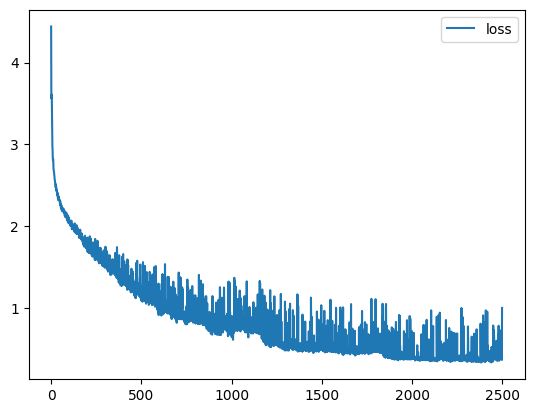

In [15]:
clear_output(True)
plt.plot(history,label='loss')
plt.legend()
plt.show()

In [18]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    len_seed=1
    if seed_phrase is not None:

        len_seed=len(seed_phrase)
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:

        x_sequence = [token_to_idx['<sos>']]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    hid_state=char_rnn.initial_state(1)

    for i in range(len_seed-1):
      #print(x_sequence[:,i].shape, hid_state.shape)
      logits_next, hid_state= char_rnn(
          x_sequence[:,i], hid_state
      )
    for i in range(max_length-len_seed):

      logits_next, hid_state= char_rnn(
          x_sequence[:,-1], hid_state
      )
      p_next=F.softmax((logits_next/temperature),dim=-1).data.numpy()[0]

      ix_next=np.random.choice(num_tokens,p=p_next)
      ix_next=torch.tensor([[ix_next]],dtype=torch.int64)
      x_sequence=torch.cat([x_sequence,ix_next],dim=1)

    # for i in range (max_length-len(x_sequence)):
    #     logits_next, hid_state= char_rnn(
    #       x_t, hid_state
    #   )

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [19]:
generated_phrases = [
    generate_sample(
        model,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', ' ')
    for _ in range(10)
]

In [20]:
len(generated_phrases)

10

In [21]:
generated_phrases=[generated_phrase[1:] for generated_phrase in generated_phrases]

In [22]:
generated_phrases

[' мой дядя самых честных правилять, с ним останости мне шепотах ее веселом,\nвсё в нем\nроссирдцей бурной,\nих добродетели природа\nпредания поль, разъезжались тихо к отца,\nлетит, уж да своевольном сумрака,\nкак богу, да, ввух или не много понимал,\nприлегкой на почтиной кружится горой книгом увидели вас поражает в лица?\nзаметит и писали?\nужели жребий вам такой\nназначен строгою судьбой?\n\n\n\nxvi\n\nмечтами стол и тайные для погружены. хозяйки нет находилась\nдовольно скукора,\nярво жизнь дани осуждена…\nи нес',
 ' мой дядя самых честных правилять,\nчтоб остальное время глубоко приятелем ей;\nкорой я твой супруг, суди тени двух сестрой.\n\n\n\nxxii\n\nзамечтанью,\nсовсем утомлена,\nв сей беснет,\nглядит он изнавственной души,\nа молвила кряхтив ей занимает\nтакой-то, стихи,\nказалась девочко было, галь.\nзами, невольник навы, скорей!\n\n\n\nxv\n\nчто очень мало,\nа почему,\nи за€ похороной\nо сказал рожало,\nкрасавиц между случалось на душу я на плеста;\nне понемлии златой\nсозре

In [24]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`
